#### In this tutorial we are going to use GenRA to evaluate a dataset of LD50 data from acute rat oral toxicity studies and make a prediction for a target chemical of interest.

Let import our datasets and start looking at them:

In [4]:
#Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl

In [5]:
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

In [6]:
import openpyxl

Name the relevant directory paths where the data files are located

In [7]:
raw_dir = '/home/grace/Documents/python/UNC_RAx_Tutorial/data/raw/'

In [8]:
#Import the acute toxicity chemical dataset that has been captured into 2 worksets in Excel called 'first' and 'last'
#Here we are going to use openpyxl to open these worksheets

CMO = pd.concat([pd.read_excel(raw_dir+'smi_acute.xlsx', sheet_name = 'first'), pd.read_excel(raw_dir+'smi_acute.xlsx', sheet_name = 'last')], axis =0).drop(['INPUT','FOUND_BY'],axis=1)



In [9]:
#View the first few lines of the dataset

CMO.head()

,DTXSID,PREFERRED_NAME,SMILES,QSAR_READY_SMILES
0,DTXSID5020281,1-Chloro-4-nitrobenzene,[O-][N+](=O)C1=CC=C(Cl)C=C1,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,DTXSID8020961,4-Nitroaniline,NC1=CC=C(C=C1)[N+]([O-])=O,NC1=CC=C(C=C1)[N+]([O-])=O
2,DTXSID0021834,4-Nitrophenol,OC1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
3,DTXSID2044347,4'-Methoxyacetophenone,COC1=CC=C(C=C1)C(C)=O,COC1=CC=C(C=C1)C(C)=O
4,DTXSID4025745,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1


In [10]:
#check out the shape of the dataset

CMO.shape

(7011, 4)

In [11]:
#Filter to remove records where no SMILES are available

CHM0 = CMO[CMO["SMILES"]!='-']

In [12]:
#Compute Morgan Fingerprints using RDKit

In [13]:
MOLS = dict(zip(CHM0['DTXSID'], CHM0['SMILES']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
FP0.index=MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]

RDKit ERROR: [22:02:52] Explicit valence for atom # 3 O, 3, is greater than permitted


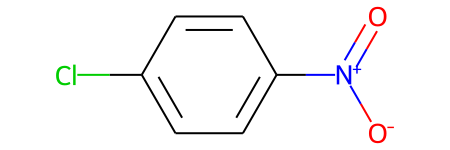

In [14]:
#Show the first structure in the MOLS dict
MOLS['DTXSID5020281']

In [15]:
#Check out the first few rows of the fingerprint df

FP0.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
DTXSID4025745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

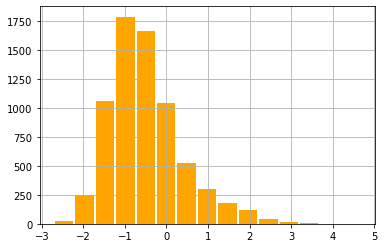

In [17]:
#Import LD50 data and view its distribution

POD0 = pd.read_csv(raw_dir+'small_acute_processed.csv').set_index('dsstox_sid')
POD0.LD50_LM.hist(bins=15,rwidth=0.9,color='orange')

In [18]:
I = FP0.index.intersection(POD0.index)
X,Y = FP0.loc[I],POD0.loc[I,'LD50_LM']

In [62]:
POD0.head()

,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,casrn,mol_weight,LD50_LM
dsstox_sid,,,,,,,,
DTXSID5020281,False,False,460.0,2.0,4.0,100-00-5,157.550003,-0.465339
DTXSID8020961,False,False,750.0,3.0,4.0,100-01-6,138.126007,-0.734786
DTXSID0021834,False,False,170.0,2.0,3.0,100-02-7,139.110001,-0.087091
DTXSID2044347,False,False,1720.0,3.0,4.0,100-06-1,150.177002,-1.058925
DTXSID4025745,False,False,1809.0,3.0,4.0,100-14-1,171.580002,-1.022972


In [19]:
#Import genra modules

In [20]:
import genra

In [21]:
from genra.rax.skl.reg import GenRAPredValue

In [22]:
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score,f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [23]:
GP1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['jaccard','euclidean']
       }


Grid3= GridSearchCV(estimator=GP1,param_grid=params,
                    n_jobs=-1,cv=5,
                    verbose=1,
                    scoring=make_scorer(r2_score))


Best3=Grid3.fit(X,Y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/grace/anaconda3/envs/UNC_RAx_Tutorial/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.8min finished


Best: 0.4281329280846896 {'metric': 'jaccard', 'n_neighbors': 8}


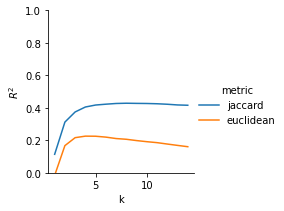

In [24]:
P = pd.DataFrame(Best3.cv_results_['params'])
P.insert(2,'score_mn',Best3.cv_results_['mean_test_score'])
P.insert(3,'score_std',Best3.cv_results_['std_test_score'])

g=sns.FacetGrid(P,hue='metric')
g.map(plt.plot,'n_neighbors','score_mn')
g.set(ylim=(0,1.0),xlabel='k',ylabel='$R^2$')
g.add_legend()
print("Best:", Best3.best_score_,Best3.best_params_)

In [25]:
from sklearn.model_selection import cross_val_predict,LeaveOneOut
from genra.rax.skl.reg import *


GC1 = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=-1)

Loo = LeaveOneOut()
Loo.get_n_splits(X)

Yp = cross_val_predict(GC1,X,Y,cv=LeaveOneOut(),n_jobs=-1,verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/grace/anaconda3/envs/UNC_RAx_Tutorial/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4992 task

In [26]:
Perf1 = pd.DataFrame(dict(Y_true=Y,Y_pred=Yp))

In [27]:
print("$R^2$ score= {:.3f}\nRMSE={:0.3f}\n"\
              .format(r2_score(Perf1['Y_true'],Perf1['Y_pred']),
                      np.sqrt(((Perf1['Y_true']-Perf1['Y_pred'])**2).mean())))


$R^2$ score= 0.517
RMSE=0.613



In [28]:
Perf1['residual']=(Perf1['Y_pred']-Perf1['Y_true'])
Perf1['mse']=(Perf1['Y_true']-Perf1['Y_pred'])**2

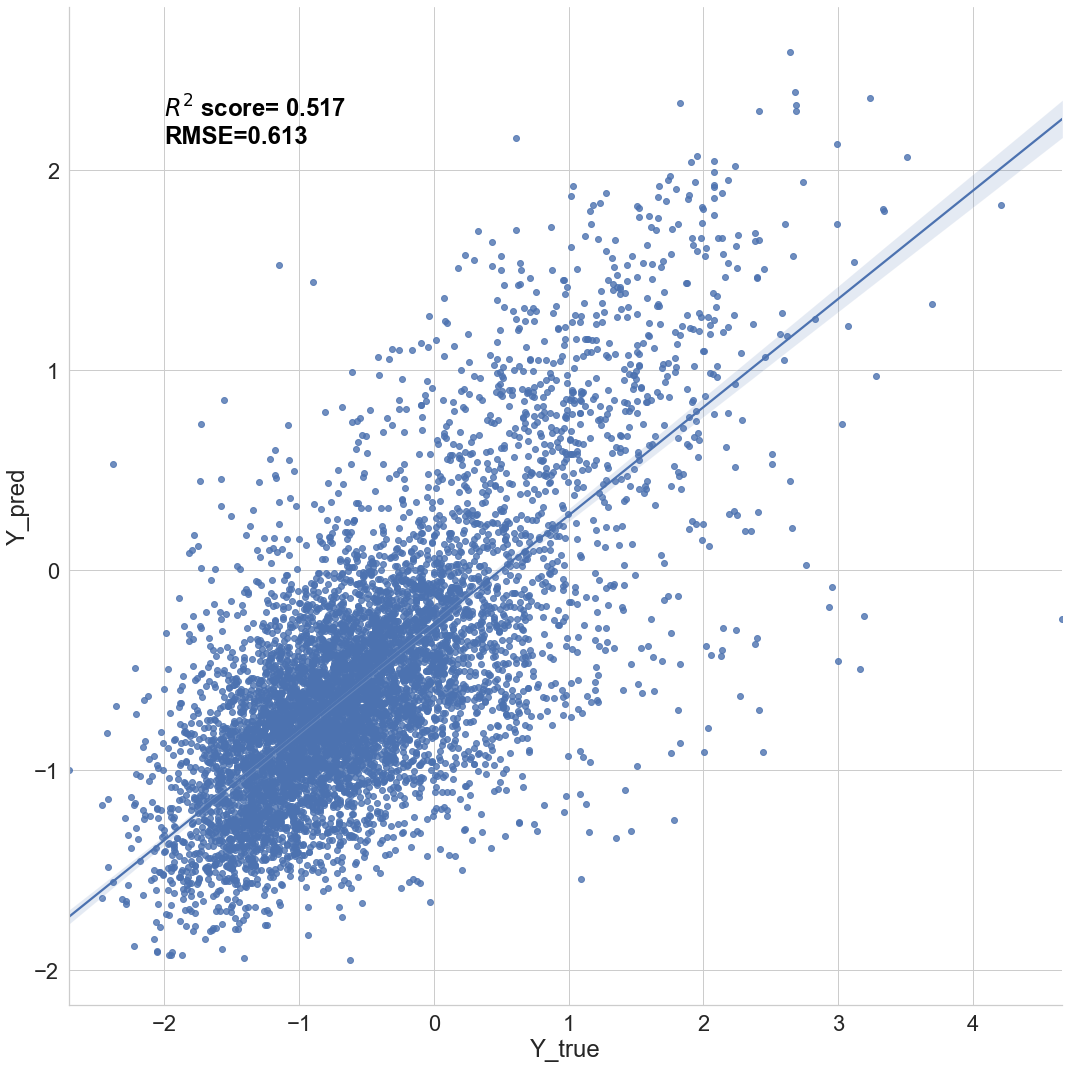

In [29]:
import seaborn as sns

sns.set(style='whitegrid',font_scale=2.0)

g=sns.lmplot(x='Y_true',y='Y_pred',data=Perf1,height=15,aspect=1.0)
txt = "$R^2$ score= {:.3f}\nRMSE={:0.3f}\n"\
              .format(r2_score(Perf1['Y_true'],Perf1['Y_pred']),
                      np.sqrt(((Perf1['Y_true']-Perf1['Y_pred'])**2).mean()))
 

for p in g.axes:
    p[0].text(-2, 2, txt, horizontalalignment='left', size='medium', color='black', weight='semibold')

In [63]:
# Extract neighbours for a specific chemical: 'DTXSID5020281'

In [32]:
from genra.rax.viz.nn import *

In [43]:
CHM_info = FP0.reset_index().rename(columns = {'index': 'DTXSID'}).merge(CHM0, on = 'DTXSID')

In [41]:
CHM0.head()

,DTXSID,PREFERRED_NAME,SMILES,QSAR_READY_SMILES
0,DTXSID5020281,1-Chloro-4-nitrobenzene,[O-][N+](=O)C1=CC=C(Cl)C=C1,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,DTXSID8020961,4-Nitroaniline,NC1=CC=C(C=C1)[N+]([O-])=O,NC1=CC=C(C=C1)[N+]([O-])=O
2,DTXSID0021834,4-Nitrophenol,OC1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
3,DTXSID2044347,4'-Methoxyacetophenone,COC1=CC=C(C=C1)C(C)=O,COC1=CC=C(C=C1)C(C)=O
4,DTXSID4025745,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1


In [48]:
CHM_info = CHM_info.set_index('DTXSID')

In [53]:
CHM_info.index.rename('ID', inplace = True)

In [60]:
CHM_info.rename(columns = {'SMILES': 'smiles', 'PREFERRED_NAME': 'chemical_name'}, inplace = True)

/home/grace/anaconda3/envs/UNC_RAx_Tutorial/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/grace/anaconda3/envs/UNC_RAx_Tutorial/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


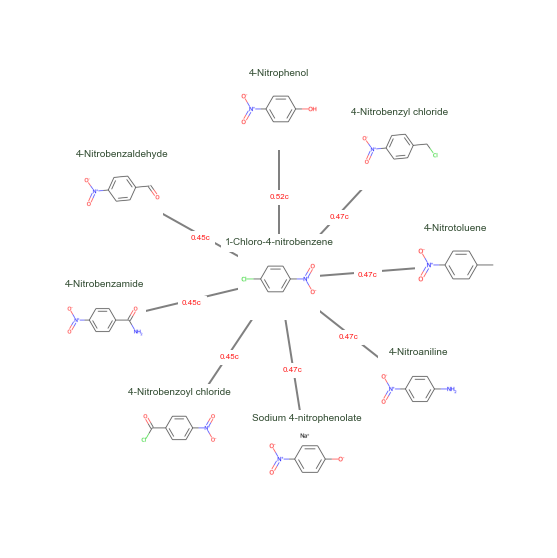

In [61]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
ax.set_axis_off()
ax.set_xlim(-600,600)
ax.set_ylim(-600,600)
target_id = 'DTXSID5020281'
GV = GenRAViewNN(rs=1.2,lw=0.2,ax=ax,th_tot=1.9*math.pi,
                 chm_name_font_size=10,
                   chm_sz=(180,180),r_min=200)
GV.loadData(FP0,np.ones(FP0.shape[0]),Info=CHM_info)
GV.draw(target_id,k=8)

In [69]:
#target_id = 'DTXSID5020281'

In [64]:
# The nearest neighbours of target_id: 'DTXSID5020281' are found by inspecting the GV object:

GV._NNi.ID

0    DTXSID5020281
1    DTXSID0021834
2    DTXSID4025745
3    DTXSID5023792
4    DTXSID8020961
5    DTXSID3027320
6    DTXSID9025742
7    DTXSID8022086
8    DTXSID5022061
Name: ID, dtype: object

In [72]:
#Look at the nearest neighbours from the chemical set

CHM0[CHM0['DTXSID'].isin(GV._NNi.ID)]

,DTXSID,PREFERRED_NAME,SMILES,QSAR_READY_SMILES
0,DTXSID5020281,1-Chloro-4-nitrobenzene,[O-][N+](=O)C1=CC=C(Cl)C=C1,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,DTXSID8020961,4-Nitroaniline,NC1=CC=C(C=C1)[N+]([O-])=O,NC1=CC=C(C=C1)[N+]([O-])=O
2,DTXSID0021834,4-Nitrophenol,OC1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
4,DTXSID4025745,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1
929,DTXSID9025742,4-Nitrobenzoyl chloride,[O-][N+](=O)C1=CC=C(C=C1)C(Cl)=O,[O-][N+](=O)C1=CC=C(C=C1)C(Cl)=O
4482,DTXSID5022061,4-Nitrobenzaldehyde,[O-][N+](=O)C1=CC=C(C=O)C=C1,[O-][N+](=O)C1=CC=C(C=O)C=C1
24,DTXSID8022086,4-Nitrobenzamide,NC(=O)C1=CC=C(C=C1)[N+]([O-])=O,NC(=O)C1=CC=C(C=C1)[N+]([O-])=O
1241,DTXSID3027320,Sodium 4-nitrophenolate,[Na+].[O-]C1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
1985,DTXSID5023792,4-Nitrotoluene,CC1=CC=C(C=C1)[N+]([O-])=O,CC1=CC=C(C=C1)[N+]([O-])=O


In [76]:
I = Y.index.intersection(GV._NNi.ID)

In [81]:
Y_i  =Y.loc[I]

In [82]:
# LD50_LM of neighbours
Y_i

DTXSID5020281   -0.465339
DTXSID8020961   -0.734786
DTXSID0021834   -0.087091
DTXSID4025745   -1.022972
DTXSID9025742   -1.479704
DTXSID5022061   -1.492773
DTXSID8022086   -0.457143
DTXSID3027320   -0.298076
DTXSID5023792   -1.174596
Name: LD50_LM, dtype: float64

In [83]:
X_i = X.loc[I]

In [84]:
X_i

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID9025742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5022061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8022086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID3027320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5023792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Identify chem FP for target chem

In [87]:
X_t = X_i.loc[target_id]

In [ ]:
# Make prediction using the neighbours identified

In [209]:
GP_i = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=-1)

In [211]:
GP_i.fit(X_i[1:], Y_i[1:])

GenRAPredValue(algorithm='brute', leaf_size=30, metric='jaccard',
               metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
               sim_params=None)

In [212]:
Y_t = GP_i.predict([X_t])

In [228]:
#Predicted value of target chemical
Y_t

array([-0.82986533])

#### Computing the similarity weighted activity manually

In [159]:
from scipy.spatial.distance import pdist, squareform

D_mgrn = pd.DataFrame(squareform(pdist(X, 'jaccard')), columns = X.index, index = X.index)
S_mgrn = 1-D_mgrn
S_mgrn.head()

,DTXSID5020281,DTXSID8020961,DTXSID0021834,DTXSID2044347,DTXSID4025745,DTXSID9059208,DTXSID7026653,DTXSID6026080,DTXSID80870440,DTXSID7026655,...,DTXSID70244252,DTXSID9046998,DTXSID70244257,DTXSID60244281,DTXSID0073245,DTXSID3044752,DTXSID80244288,DTXSID0022143,DTXSID6020303,DTXSID2025395
DTXSID5020281,1.000000,0.466667,0.517241,0.095238,0.468750,0.424242,0.156250,0.125000,0.388889,0.378378,...,0.163934,0.000000,0.052632,0.040000,0.000000,0.023810,0.00000,0.022222,0.029412,0.000000
DTXSID8020961,0.466667,1.000000,0.466667,0.095238,0.424242,0.424242,0.121212,0.125000,0.388889,0.378378,...,0.059701,0.000000,0.071429,0.040000,0.057143,0.048780,0.00000,0.045455,0.029412,0.000000
DTXSID0021834,0.517241,0.466667,1.000000,0.121951,0.424242,0.424242,0.156250,0.161290,0.388889,0.378378,...,0.059701,0.000000,0.071429,0.061224,0.000000,0.048780,0.00000,0.045455,0.000000,0.000000
DTXSID2044347,0.095238,0.095238,0.121951,1.000000,0.088889,0.361111,0.258065,0.266667,0.083333,0.177778,...,0.106061,0.026316,0.107143,0.080000,0.054054,0.097561,0.02500,0.116279,0.027778,0.032258
DTXSID4025745,0.468750,0.424242,0.424242,0.088889,1.000000,0.388889,0.142857,0.114286,0.358974,0.421053,...,0.072464,0.025641,0.050000,0.057692,0.025641,0.045455,0.02439,0.042553,0.085714,0.031250


In [161]:
target_chm = S_mgrn.DTXSID5020281.values

In [162]:
target_chm 

array([1.        , 0.46666667, 0.51724138, ..., 0.02222222, 0.02941176,
       0.        ])

In [163]:
S_mgrn[S_mgrn.index == 'DTXSID5020281']

,DTXSID5020281,DTXSID8020961,DTXSID0021834,DTXSID2044347,DTXSID4025745,DTXSID9059208,DTXSID7026653,DTXSID6026080,DTXSID80870440,DTXSID7026655,...,DTXSID70244252,DTXSID9046998,DTXSID70244257,DTXSID60244281,DTXSID0073245,DTXSID3044752,DTXSID80244288,DTXSID0022143,DTXSID6020303,DTXSID2025395
DTXSID5020281,1.0,0.466667,0.517241,0.095238,0.46875,0.424242,0.15625,0.125,0.388889,0.378378,...,0.163934,0.0,0.052632,0.04,0.0,0.02381,0.0,0.022222,0.029412,0.0


In [164]:
ids_chem = {i:x for i, x in enumerate(S_mgrn.index)}

In [215]:
temp_chem = np.argpartition(-target_chm, 9)
chem_nn = temp_chem[:9]
print(chem_nn)


[ 926 6947    2    1    4 6204    0 4990 4452]


In [216]:
target_chm[chem_nn]

array([0.45454545, 0.46666667, 0.51724138, 0.46666667, 0.46875   ,
       0.46666667, 1.        , 0.45454545, 0.4516129 ])

In [217]:
nn_chem = []
for x in chem_nn:
    nn_chem.append(ids_chem[x])

In [218]:
mydict = {k:v for k,v in list(zip(nn_chem,target_chm[chem_nn]))}

In [219]:
Yb = Y.reset_index()

In [220]:
Yb.columns = ['dtxsid', 'LD50_LM']

In [221]:
Yh =Yb[Yb.dtxsid.isin(nn_chem)]

In [222]:
Yh['Jaccard'] = Yh['dtxsid'].map(mydict)

In [223]:
Yh

,dtxsid,LD50_LM,Jaccard
0,DTXSID5020281,-0.465339,1.000000
1,DTXSID8020961,-0.734786,0.466667
2,DTXSID0021834,-0.087091,0.517241
4,DTXSID4025745,-1.022972,0.468750
926,DTXSID9025742,-1.479704,0.454545
4452,DTXSID5022061,-1.492773,0.451613
4990,DTXSID8022086,-0.457143,0.454545
6204,DTXSID3027320,-0.298076,0.466667
6947,DTXSID5023792,-1.174596,0.466667


In [190]:
def wtavg(df):
    sim = df.Jaccard
    acts = df.LD50_LM
    return np.sum(acts.values * sim.values)/np.sum(sim.values)


In [229]:
# Predicted similarity weighted activity of target matches!!

In [224]:
wtavg(Yh[Yh['dtxsid'] != 'DTXSID5020281'])

-0.8298653277792956

In [230]:
# Checking neighbours identified manually

In [225]:
Yh.dtxsid.tolist()

['DTXSID5020281',
 'DTXSID8020961',
 'DTXSID0021834',
 'DTXSID4025745',
 'DTXSID9025742',
 'DTXSID5022061',
 'DTXSID8022086',
 'DTXSID3027320',
 'DTXSID5023792']

In [226]:
Y_i.reset_index()['index'].tolist()

['DTXSID5020281',
 'DTXSID8020961',
 'DTXSID0021834',
 'DTXSID4025745',
 'DTXSID9025742',
 'DTXSID5022061',
 'DTXSID8022086',
 'DTXSID3027320',
 'DTXSID5023792']

In [239]:
assert (Y_i.reset_index()['index'].tolist() ==  Yh.dtxsid.tolist())

In [241]:
# Neighbours identified are equal

In [240]:
[e for e in Y_i.reset_index()['index'].tolist() if e not in Yh.dtxsid.tolist()]

[]